In [1]:
import pickle
import warnings
import sys
from IPython.display import Image, HTML

import pandas as pd
import numpy as np
from scipy.stats import norm, uniform
import pymc3 as pm
from theano import shared

import seaborn as sb
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import ticker as mtick
import cmocean.cm as cmo
import arviz as ar

rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [2]:
print('Versions:')
print('---------')
print(f'python:  {sys.version.split("|")[0]}')
print(f'numpy:   {np.__version__}')
print(f'pandas:  {pd.__version__}')
print(f'seaborn: {sb.__version__}')
print(f'pymc3:   {pm.__version__}')
print(f'arviz:   {ar.__version__}')

Versions:
---------
python:  3.6.8 
numpy:   1.15.4
pandas:  0.24.0
seaborn: 0.9.0
pymc3:   3.6
arviz:   0.3.2


In [3]:
%matplotlib inline
warnings.filterwarnings('ignore',  category=FutureWarning)

In [4]:
def make_lower_triangle(gs):
    for i, j in zip(*np.triu_indices_from(gs.axes, 1)):
        gs.axes[i, j].set_visible(False)
    gs.axes[0,0].set_xlabel(gs.axes[0,0].get_ylabel())
    gs.axes[0,0].set_ylabel('')
    gs.axes[0,0].set_yticks([])

# <center><u>Probabilistic Programming for the Busy Modeler</u></center>

<a id='TOP'></a>

## Notebook Contents
0. [Motivation](#MOTIV)
1. [Basics: Joint probability, Inverse probability and Bayes' Theorem](#BASIC)
2. [Inferring Chl](#JustCHL)
    1. [Grid Approximation](#GRID)
        1. [Impact of priors](#PriorImpact)
        2. [Impact of data set size](#DataImpact)
    2. [MCMC](#MCMC)
    3. [PyMC3](#PyMC3)
3. [Regression](#Reg)
    1. [Regression in PyMC3](#RegPyMC3)
    2. [Checking Priors](#PriorCheck)
    3. [Data Review, Model Fitting and Posterior Mining](#Mining)
    4. [Flavors of Uncertainty](#UNC)

<a id='MOTIV'></a>

#### <font color='purple'><u>Probabilistic Programming is a good idea because...:</u></font>
* Transparent model building
    * one framework to rule them all
    * assumptions are visible and verifiable
    * models are criticizable and can be improved upon iteratively
    * models are reproducible

* Generative models
    * data can be simulated
    * model assumptions can be checked and corrected
    * fit models can be understood through counterfactuals
    * after fitting out-of-sample data can be predicted

* Use of Probability
    * Uncertainty estimation
    * Information theory for modeling choices, model selection/blending
    * Decision theory for risk assessment of alternative choices

* Reduce overfitting risk
    * built-in regularization
    * model selection based on more than fitting score
    * maintainance of model predictive performance after deployment

* From small noisy data sets to global prediction
    * data efficiency $\rightarrow$ clever priors
* Global or regional models?
    * ... or a bit of both?

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    $\rightarrow$The basics<br>
    $\rightarrow$Under the hood: inferring chlorophyll distribution<br>
    $\rightarrow$Regression: adding a predictor to estimate chlorophyll<br><br>
* <font color='blue'> Probabilistic modeling for the not-so-beginner<br>
    $\rightarrow$More complicated models, accounting for input/output uncertainty, imputing missing data<br>
    $\rightarrow$Empirical vs. semi-analytical: a useful dichotomy?<br>
    $\rightarrow$Causality and the backdoor criterion<br>
    $\rightarrow$Comparing models through information theory<br>
    $\rightarrow$Hierarchical probabilistic models</font><br>

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    <font color='red'>$\rightarrow$The basics</font><br>
    $\rightarrow$Under the hood: inferring chlorophyll distribution<br>
    $\rightarrow$Regression: adding a predictor to estimate chlorophyll

<a id='BASIC'></a>
[Back to Contents](#TOP)

## The Basics:

* Joint probability of two events $A$, $B$:
$$P(A, B)=P(A|B)\times P(B)=P(B|A)\times P(A)$$

* A, B independent: $$P(A|B) = P(A)\ \leftrightarrow P(A,B) = P(A)\times P(B)$$

* Inverse probability:$$\boxed{P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}}$$ 
$\rightarrow$usually referred to as Bayes' theorem

* Log Probability:
$$\prod_i P(x_i) = e^{\sum_i{log(P(x_i))}}$$

### $\Rightarrow$Extending Bayes' theorem to building models informed by data

* Hypotheses ($H$): values that a given model's parameters might take
    * naive in the extreme: $H \in (-\infty, \infty)$, with equal probability everywhere
    * informative: results in reasonable model output
* formulate initial opinion on what $H$ might include and with what probability, $P(H)$
* collect data ($D$) 
* update $P(H)$ using $D$ and inverse probability (Bayes' theorem)


$$\frac{P(H)\times P(D|H)}{P(D)} = P(H|D)$$ 

Getting rid of the evidence...
$$ P(H) \times P(D|H) \propto P(H|D)$$

#### The prior
$$\underline{P(H)}\times P(D|H) \propto P(H|D)$$

* $H$: set of values that model parameters might take with corresponding probability
* h=x & p(h=x)
* use a probability distribution to express $P(H)$

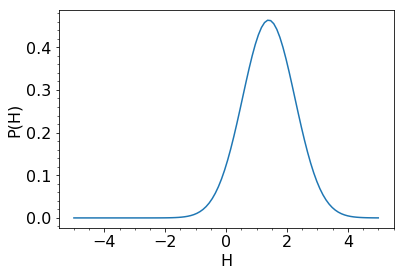

In [5]:
# build 1D grid of possible values
h = np.linspace(-5, 5, num=100)
μ_prior = 1.4 
σ_prior = 0.86
# compute probability at each a h
p_h = norm.pdf(h, loc=μ_prior, scale=σ_prior) 
pl.plot(h, p_h); pl.ylabel('P(H)'); pl.xlabel('H');

#### The likelihood

$$P(H)\times \underline{P(D|H)} \propto  P(H|D)$$


* probability of the data, $D$, *given* $H$
* classically maximized$\rightarrow$best fit $\rightarrow$NOT DONE HERE!
* data may misrepresent the big picture

#### The posterior:

$$P(H)\times P(D|H) \propto \underline{P(H|D)}$$


* it's what we're after!!!
* updated probability of $H$ after collecting $D$
* used as prior for next iteration $P(H|D)\rightarrow P(H)$
* $P(H|D)$ naturally yields uncertainty

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    $\rightarrow$~~The basics~~<br>
    <font color='red'>$\rightarrow$Under the hood: inferring chlorophyll distribution</font><br>
    $\rightarrow$Regression: adding a predictor to estimate chlorophyll

<a id='JustCHL'></a>
[Back to Contents](#TOP)

## Under the hood: Inferring chlorophyll distribution
* <font color='red'>Grid approximation: computing probability for all parameter values</font>
* Magical MCMC: how it works
* Probabilistic Programming with PyMC3: industrial grade MCMC

[Back to Contents](#TOP)
<a id='GRID'></a>

### Grid approximation: computing probability for all parameter values<br>

$\ \ \ \rightarrow$mechanistically straightforward<br>
$\ \ \ \rightarrow$computationally expensive!

In [6]:
df_data = pd.read_pickle('./pickleJar/df_logMxBlues.pkl')

In [7]:
df_data.insert(df_data.columns.get_loc('mxBlId'), 'mxBlId2',
           df_data.loc[:, ['rrs443_l', 'rrs510_l']].idxmax(axis=1).str.replace('_l', ''))

df_data.insert(df_data.columns.get_loc('MxBl-Gr'), 'MxBl-Gr2',
          df_data.loc[:, ['rrs443_l', 'rrs510_l']].max(axis=1) - df_data.loc[:, 'rrs555_l'])

df_data.head().T

,0,1,2,3,4
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778
rrs510_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.70144
rrs555_l,-2.26695,-2.36376,-2.34046,-2.59924,-2.80625
rrs670_l,-3.07818,-3.13471,-3.16042,-3.50443,-3.79611
mxBl_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.6778
mxBlId2,rrs510,rrs510,rrs510,rrs510,rrs510
mxBlId,rrs510,rrs510,rrs510,rrs510,rrs489
MxBl-Gr2,-0.0257098,-0.0242776,-0.0205022,0.0399411,0.104812


In [8]:
df_data[['MxBl-Gr', 'chl_l']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 2 columns):
MxBl-Gr    4453 non-null float64
chl_l      4127 non-null float64
dtypes: float64(2)
memory usage: 104.5 KB


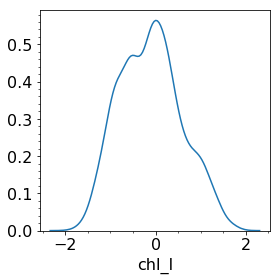

In [9]:
f, ax = pl.subplots(figsize=(4,4))
sb.kdeplot(df_data.chl_l, ax=ax, legend=False);
ax.set_xlabel('chl_l');
f.tight_layout()
f.savefig('./figJar/Presentation/fig1_chl.svg', dpi=300, format='svg')

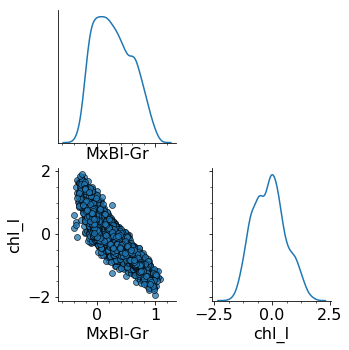

In [10]:
g = sb.PairGrid(df_data.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
f = pl.gcf()
f1 = './figJar/Presentation/fig_pairwise_1.svg'
f.savefig(f1, format='svg', dpi=300)

### Grid approximation:


<br>$\rightarrow$To infer chlorophyll distribution parameters
* Build a model that approximates the process that generates the observations
* Build the grid of model parameters
* <u>Propose priors</u>
* <u>Compute likelihood</u>
* <u>Compute posterior</u>

### Grid approximation:


<br>$\rightarrow$To infer chlorophyll distribution parameters
* Build a model that approximates the process that generates the observations
    * Gaussian
    * Hypotheses concern mean $\mu$ and standard deviation $\sigma$
* Build the grid of model parameters
    * 2D grid of $(\mu, \sigma)$ pair
* <u>Propose priors</u>
    * define priors for both $\mu$ and $\sigma$
* <u>Compute likelihood</u>
* <u>Compute posterior</u>

<img src='./figJar/Presentation/tutorial_1_1.png' height=50>

Define grid with axes $\mu$(mean) and $\sigma$ (std. dev.)

In [11]:
μ = np.linspace(-2, 2, num=200) # μ-axis
σ = np.linspace(0, 2, num=200) # σ-axis

In [12]:
df_grid = pd.DataFrame([[μ_i, σ_i]
                        for σ_i in σ for μ_i in μ],
                        columns=['μ', 'σ'])

In [13]:
print(df_grid.shape)
df_grid.head(7)

(40000, 2)


,μ,σ
0,-2.000000,0.0
1,-1.979899,0.0
2,-1.959799,0.0
3,-1.939698,0.0
4,-1.919598,0.0
5,-1.899497,0.0
6,-1.879397,0.0


#### Define prior probability distributions for $\mu$ and $\sigma$ 
* $\mu \sim \mathcal{N}(1, 1)$: a gaussian distribution centered at 1, with an sd of 1
* $\sigma \sim \mathcal{U}(0, 2)$: a uniform distribution between 0 and 2

In [14]:
μ_prior = norm.logpdf(df_grid.μ, 1, 1)
σ_prior = uniform.logpdf(df_grid.σ, 0, 2)

<img src="./figJar/Presentation/tutorial_1_2.png">

#### Compute multi-dimensional prior probability

In [15]:
# log prior probability
df_grid['log_prior_prob'] = μ_prior + σ_prior
# straight prior probability
df_grid['prior_prob'] = np.exp(df_grid.log_prior_prob
                                - df_grid.log_prior_prob.max())

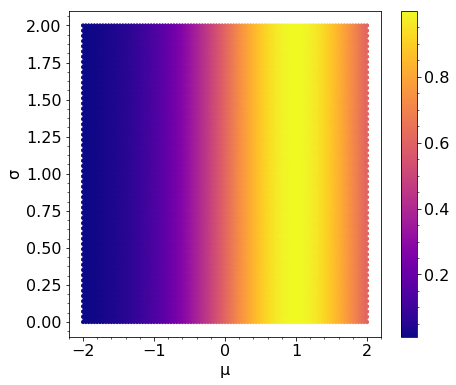

In [16]:
df_grid.plot.hexbin(x='μ', y='σ', C='prior_prob', figsize=(7,6),
                     cmap='plasma', sharex=False);

#### Bringing in the data...

<center><img src='./figJar/Presentation/fig1_chl.svg', width=400px, height=400px></center>

$\Rightarrow$Subsample the data<br>
$\ \ \ \rightarrow$computationally more tractable for grid approximation<br>
$\ \ \ \rightarrow$show the impact of prior choice

In [17]:
sample_N = 10
df_data_s = df_data.dropna().sample(n=sample_N)

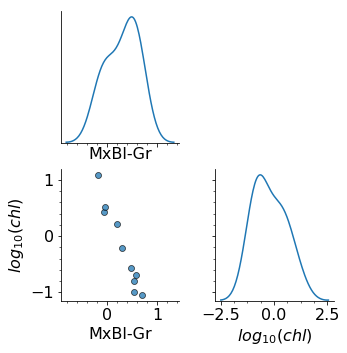

In [18]:
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

#### Compute Log-Likelihood of the data given every  pair $(\mu,\sigma)$ 

In [19]:
df_grid['LL'] = np.sum(norm.logpdf(df_data_s.chl_l.values.reshape(1, -1),
                                    loc=df_grid.μ.values.reshape(-1, 1),
                                    scale=df_grid.σ.values.reshape(-1, 1)
                                   ), axis=1)

#### Compute Posterior $P(\mu,\sigma\ | data) \propto P(data | \mu, \sigma) \times P(\mu, \sigma)$

In [20]:
# compute log-probability
df_grid['log_post_prob'] = df_grid.LL + df_grid.log_prior_prob
# convert to straight prob.
df_grid['post_prob'] = np.exp(df_grid.log_post_prob
                               - df_grid.log_post_prob.max())

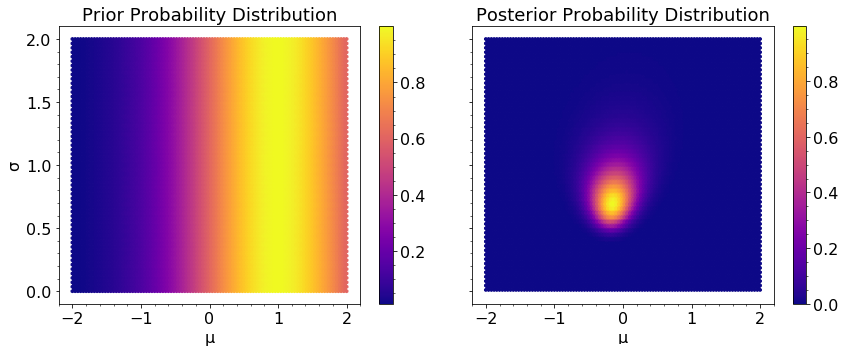

In [21]:
# Plot Multi-Dimensional Prior and Posterior
f, ax = pl.subplots(ncols=2, figsize=(12, 5), sharey=True)
df_grid.plot.hexbin(x='μ', y='σ', C='prior_prob',
                    cmap='plasma', sharex=False, ax=ax[0])
df_grid.plot.hexbin(x='μ', y='σ', C='post_prob',
                     cmap='plasma', sharex=False, ax=ax[1]);
ax[0].set_title('Prior Probability Distribution')
ax[1].set_title('Posterior Probability Distribution')
f.tight_layout()

In [22]:
# Compute Marginal Priors and Posteriors for each Parameter
df_μ = df_grid.groupby(['μ']).sum().drop('σ', axis=1)[['prior_prob',
                                                        'post_prob']
                                                      ].reset_index()
df_σ = df_grid.groupby(['σ']).sum().drop('μ', axis=1)[['prior_prob',
                                                        'post_prob']
                                                      ].reset_index() 

# Normalize Probability Distributions
df_μ.prior_prob /= df_μ.prior_prob.max()
df_μ.post_prob /= df_μ.post_prob.max()
df_σ.prior_prob /= df_σ.prior_prob.max()
df_σ.post_prob /= df_σ.post_prob.max()

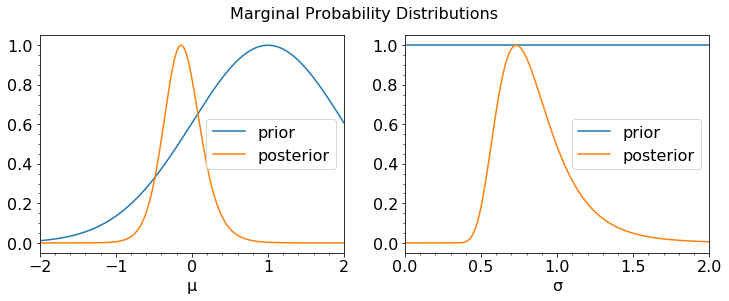

In [23]:
#Plot Marginal Priors and Posteriors
f, ax = pl.subplots(ncols=2, figsize=(12, 4))
df_μ.plot(x='μ', y='prior_prob', ax=ax[0], label='prior');
df_μ.plot(x='μ', y='post_prob', ax=ax[0], label='posterior')
df_σ.plot(x='σ', y='prior_prob', ax=ax[1], label='prior')
df_σ.plot(x='σ', y='post_prob', ax=ax[1], label='posterior');
f.suptitle('Marginal Probability Distributions', fontsize=16);

[Back to Contents](#TOP)
<a id='PriorImpact'></a>

### <u>Impact of Priors</u>

* First wrap some of the above into helper functions to avoid rewriting the same code.

In [24]:
def compute_bayes_framework(data, priors_dict):
    # build grid:
    μ = np.linspace(-2, 2, num=200)
    σ = np.linspace(0, 2, num=200)
    df_b = pd.DataFrame([[μ_i, σ_i] for σ_i in σ for μ_i in μ],
                        columns=['μ', 'σ'])
    # compute/store distributions
    μ_prior = norm.logpdf(df_b.μ, priors_dict['μ_mean'],
                          priors_dict['μ_sd'])
    σ_prior = uniform.logpdf(df_b.σ, priors_dict['σ_lo'],
                             priors_dict['σ_hi'])
    df_b['log_prior_prob'] = μ_prior + σ_prior 
    df_b['prior_prob'] = np.exp(df_b.log_prior_prob
                                    - df_b.log_prior_prob.max())
    df_b['LL'] = np.sum(norm.logpdf(data.chl_l.values.reshape(1, -1),
                                    loc=df_b.μ.values.reshape(-1, 1),
                                    scale=df_b.σ.values.reshape(-1, 1)
                                   ), axis=1)
    df_b['log_post_prob'] = df_b.LL + df_b.log_prior_prob
    df_b['post_prob'] = np.exp(df_b.log_post_prob
                               - df_b.log_post_prob.max())
    return df_b


def plot_posterior(df_, ax1, ax2):
    df_.plot.hexbin(x='μ', y='σ', C='prior_prob',
                        cmap='plasma', sharex=False, ax=ax1)
    df_.plot.hexbin(x='μ', y='σ', C='post_prob',
                         cmap='plasma', sharex=False, ax=ax2);
    ax1.set_title('Prior Probability Distribution')
    ax2.set_title('Posterior Probability Distribution')
    
    
def plot_marginals(df_, ax1, ax2, plot_prior=True):
    df_μ = df_.groupby(['μ']).sum().drop('σ',
                                         axis=1)[['prior_prob',
                                                  'post_prob']
                                                ].reset_index()
    df_σ = df_.groupby(['σ']).sum().drop('μ',
                                         axis=1)[['prior_prob',
                                                  'post_prob']
                                                ].reset_index() 
    
    # Normalize Probability Distributions
    df_μ.prior_prob /= df_μ.prior_prob.max()
    df_μ.post_prob /= df_μ.post_prob.max()
    df_σ.prior_prob /= df_σ.prior_prob.max()
    df_σ.post_prob /= df_σ.post_prob.max()

    #Plot Marginal Priors and Posteriors
    if plot_prior:
        df_μ.plot(x='μ', y='prior_prob', ax=ax1, label='prior');
        df_σ.plot(x='σ', y='prior_prob', ax=ax2, label='prior')
    df_μ.plot(x='μ', y='post_prob', ax=ax1, label='posterior')
    df_σ.plot(x='σ', y='post_prob', ax=ax2, label='posterior');

Try two priors:
1. $\mu \sim \mathcal{N}(1, 1)$, $\sigma \sim \mathcal{U}(0, 2)$ - a weakly informative prior

In [25]:
priors=dict(μ_mean=1, μ_sd=1, σ_lo=0, σ_hi=2)
df_grid_1 = compute_bayes_framework(df_data_s, priors_dict=priors)

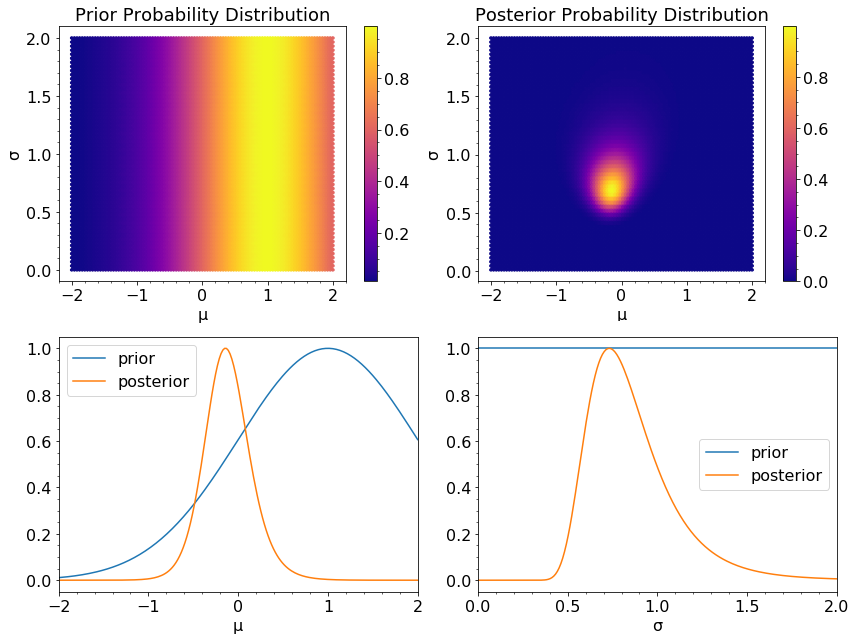

In [26]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_1, axp[0], axp[1])
plot_marginals(df_grid_1, axp[2], axp[3])
f.tight_layout()

2. $\mu \sim \mathcal{N}(-1.5, 0.1)$, $\sigma \sim \mathcal{U}(0, 2)$ - a strongly informative prior

In [27]:
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
df_grid_2 = compute_bayes_framework(df_data_s, priors_dict=priors)

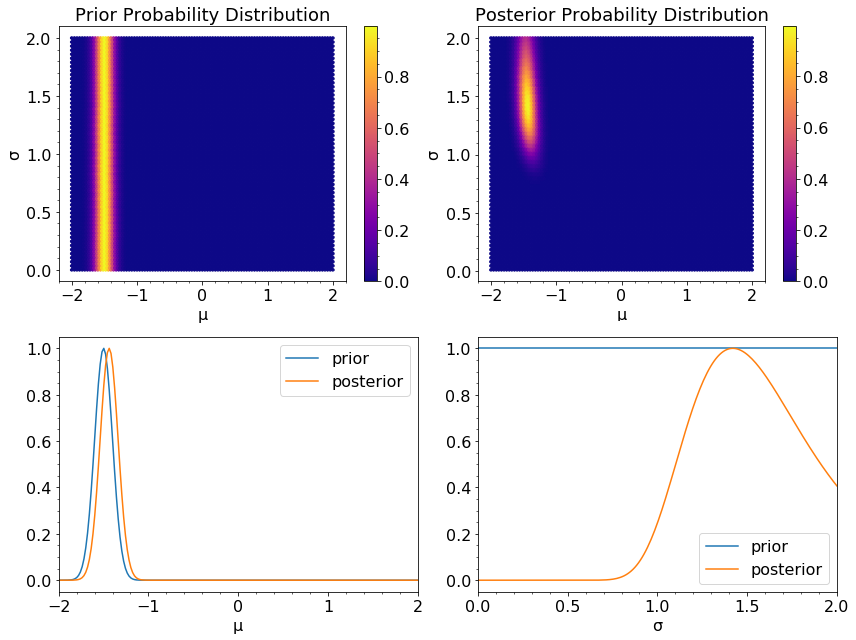

In [28]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_2, axp[0], axp[1])
plot_marginals(df_grid_2, axp[2], axp[3])
f.tight_layout()

### <u>Impact of data set size</u>
* sub-sample size is now 500 samples,
* same two priors used

In [29]:
sample_N = 500

# compute the inference dataframe
df_data_s = df_data.dropna().sample(n=sample_N)

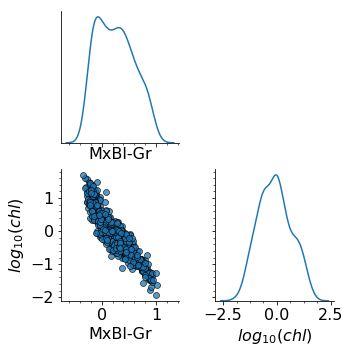

In [30]:
# display the new sub-sample
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

In [31]:
%%time
# set priors
priors=dict(μ_mean=1, μ_sd=1, σ_lo=0, σ_hi=2)
df_grid_3 = compute_bayes_framework(df_data_s, priors_dict=priors)

CPU times: user 1.33 s, sys: 741 ms, total: 2.07 s
Wall time: 1.91 s


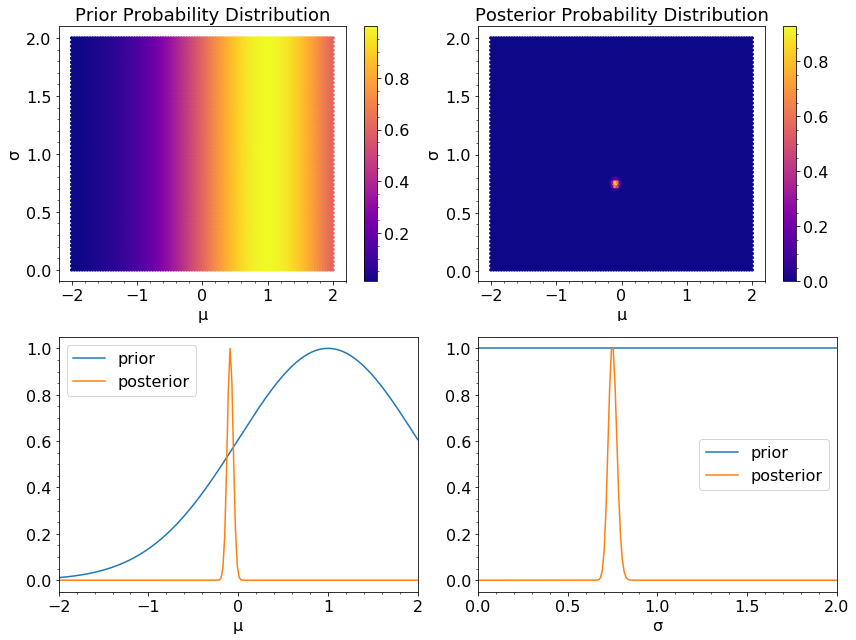

In [32]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_3, axp[0], axp[1])
plot_marginals(df_grid_3, axp[2], axp[3])
f.tight_layout()

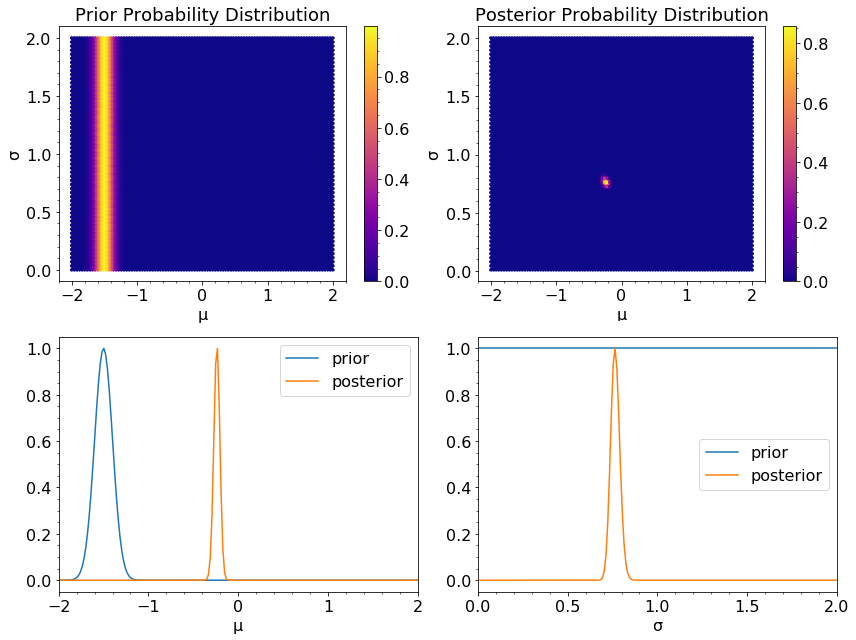

In [33]:
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
df_grid_4 = compute_bayes_framework(df_data_s, priors_dict=priors)

f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_4, axp[0], axp[1])
plot_marginals(df_grid_4, axp[2], axp[3])
f.tight_layout()

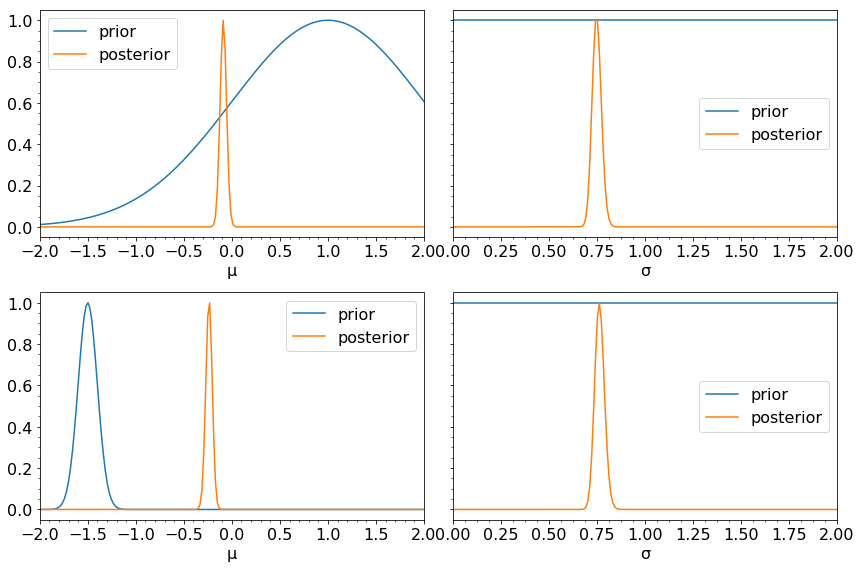

In [34]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 8), sharey=True)
axp = axp.ravel()
plot_marginals(df_grid_3, axp[0], axp[1])
plot_marginals(df_grid_4, axp[2], axp[3])
f.tight_layout()

***And using all the data?***

In [35]:
%%time
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
try:
    df_grid_all_data= compute_bayes_framework(df_data, priors_dict=priors)
except MemoryError:
    print("OUT OF MEMORY!")
    print("--------------")

OUT OF MEMORY!
--------------
CPU times: user 2.22 s, sys: 4.42 s, total: 6.64 s
Wall time: 21.9 s


##### Probabilistic modeling for the beginner
* <font color='red'>Baby steps: Inferring chlorophyll distribution</font>
    * ~~Grid approximation: computing probability everywhere~~
    * <font color='red'>Magical MCMC: Dealing with computational complexity</font>
    * Probabilistic Programming with PyMC3: Industrial grade MCMC

[Back to Contents](#TOP)
<a id="MCMC"></a>

### <u>Magical MCMC: Dealing with computational complexity</u>

* Grid approximation:
    * useful for understanding mechanics of Bayesian computation
    * computationally intensive
    * impractical and often intractable for large data sets or high-dimension models

    
* MCMC allows sampling <u>where it **probabilistically matters**</u>:
    * compute current probability given location in parameter space
    * propose jump to new location in parameter space
    * compute new probability at proposed location
    * jump to new location if $\frac{new\ probability}{current\ probability}>1$ 
    * jump to new location if $\frac{new\ probability}{current\ probability}>\gamma\in [0, 1]$
    * otherwise stay in current location

In [36]:
def mcmc(data, μ_0=0.5, n_samples=1000,):
    data = data.reshape(1, -1)
    σ=0.75 # keep σ fixed for simplicity
    trace_μ = np.nan * np.ones(n_samples) # trace: where the sampler has been
    trace_μ[0] = μ_0 # start with a first guess
    for i in range(1, n_samples):
        proposed_μ = norm.rvs(loc=trace_μ[i-1], scale=0.1, size=1)
        prop_par_dict = dict(μ=proposed_μ, σ=σ)
        curr_par_dict = dict(μ=trace_μ[i-1], σ=σ)
        log_prob_prop = get_log_lik(data, prop_par_dict
                                   ) + get_log_prior(prop_par_dict)
        log_prob_curr = get_log_lik(data, curr_par_dict
                                   ) + get_log_prior(curr_par_dict) 
        ratio = np.exp(log_prob_prop -  log_prob_curr)
        if ratio > 1:
            # accept proposal
            trace_μ[i] = proposed_μ
        else:
            # evaluate low proba proposal
            if uniform.rvs(size=1, loc=0, scale=1) > ratio:
                # reject proposal
                trace_μ[i] = trace_μ[i-1]    
            else:
                # accept proposal
                trace_μ[i] = proposed_μ
    return trace_μ

In [37]:
 def get_log_lik(data, param_dict):
    return np.sum(norm.logpdf(data, loc=param_dict['μ'],
                              scale=param_dict['σ']
                             ),
                  axis=1)

def get_log_prior(par_dict, loc=1, scale=1):
    return norm.logpdf(par_dict['μ'], loc=loc, scale=scale)

#### Timing MCMC

In [38]:
%%time
mcmc_n_samples = 2000
trace = mcmc(data=df_data_s.chl_l.values, n_samples=mcmc_n_samples)

CPU times: user 1.68 s, sys: 3.6 ms, total: 1.69 s
Wall time: 1.8 s


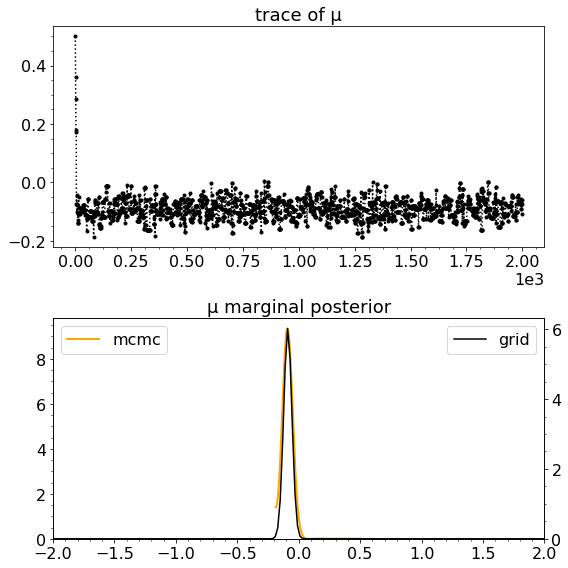

In [39]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
ax[0].plot(np.arange(mcmc_n_samples), trace, marker='.',
           ls=':', color='k')
ax[0].set_title('trace of μ')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(trace, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
df_μ = df_grid_3.groupby(['μ']).sum().drop('σ',
                                     axis=1)[['post_prob']
                                            ].reset_index()
ax2 = ax[1].twinx()
df_μ.plot(x='μ', y='post_prob', ax=ax2, color='k',
         label='grid',)
ax2.set_ylim(bottom=0);
ax2.legend(loc='upper right')
f.tight_layout()

In [40]:
%%time
samples = 2000
trace = mcmc(data=df_data.chl_l.values, n_samples=samples)

CPU times: user 2.58 s, sys: 0 ns, total: 2.58 s
Wall time: 2.58 s


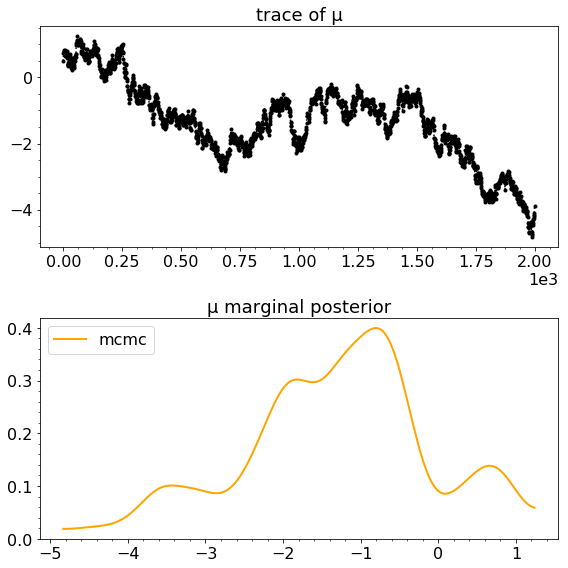

In [41]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
ax[0].plot(np.arange(samples), trace, marker='.',
           ls=':', color='k')
ax[0].set_title('trace of μ')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(trace, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
f.tight_layout()

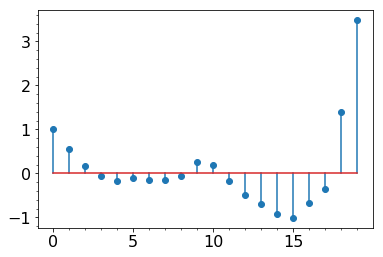

In [42]:
f, ax = pl.subplots()
ax.stem(pm.autocorr(trace[:20]));

In [43]:
f.savefig('./figJar/Presentation/stem1.svg', dpi=300, format='svg');

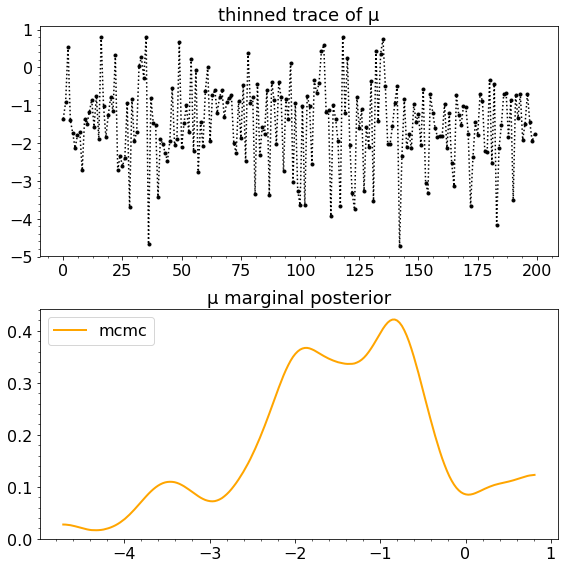

In [44]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
thinned_trace = np.random.choice(trace[100:], size=200, replace=False)
ax[0].plot(np.arange(200), thinned_trace, marker='.',
           ls=':', color='k')
ax[0].set_title('thinned trace of μ')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(thinned_trace, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
f.tight_layout()

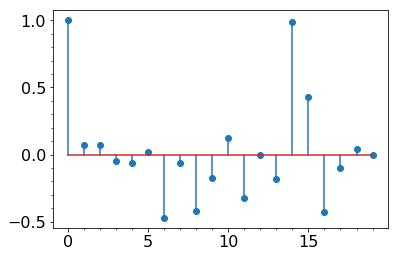

In [45]:
f, ax = pl.subplots()
ax.stem(pm.autocorr(thinned_trace[:20]));

In [46]:
f.savefig('./figJar/Presentation/stem2.svg', dpi=300, format='svg');

What's going on? $\rightarrow$ highly autocorrelated trace makes for inadequate parameter space exploration and poor convergence...

<table><tr>
    <td><img src='./figJar/Presentation/stem1.svg'></td>
    <td><img src='./figJar/Presentation/stem2.svg'></td>
    </tr>
</table>

* Metropolis MCMC<br>
    $\rightarrow$ easy to implement + memory efficient<br>
    $\rightarrow$ annoying to use
* Now what??

* **Hamiltonian Monte Carlo (HMC)** samplers work much better
* HMC complexity: $O(D^{\frac{5}{4}})$,
* Much faster convergence
* Well mixed traces are a signature and an easy diagnostic
* HMC does require a lot of tuning,
* Not practical for the inexperienced applied statistician or scientist

* A flavor of HMC the No-U-Turn Sampler (NUTS) automates a lot of this tuning
* NUTS is also scales well to complex problems with many parameters (1000's)
* **PyMC3** is a *Probabilistic Programming* library in Python that implements the NUTS sampler among others...

##### Probabilistic modeling for the beginner
* <font color='red'>Baby steps: Inferring chlorophyll distribution</font>
    * ~~Grid approximation: computing probability everywhere~~
    * ~~MCMC: how it works~~
    * <font color='red'>Probabilistic Programming with PyMC3: Industrial grade MCMC </font>

[Back to Contents](#TOP)
<a id='PyMC3'></a> 

### <u>Probabilistic Programming with PyMC3</u>

* relatively simple syntax
* easily used in conjuction with widely used python scientific data structures<br>
    $\rightarrow$numpy arrays <br>
    $\rightarrow$pandas dataframes
* models of reasonable complexity span ~10-20 lines.

In [47]:
with pm.Model() as m1:
    μ_ = pm.Normal('μ', mu=1, sd=1)
    σ = pm.Uniform('σ', lower=0, upper=2)
    lkl = pm.Normal('likelihood', mu=μ_, sd=σ,
                    observed=df_data.chl_l.dropna())

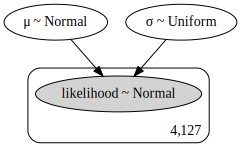

In [48]:
pm.model_to_graphviz(m1)

In [49]:
with m1:
    trace_m1 = pm.sample(2000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1270.61draws/s]


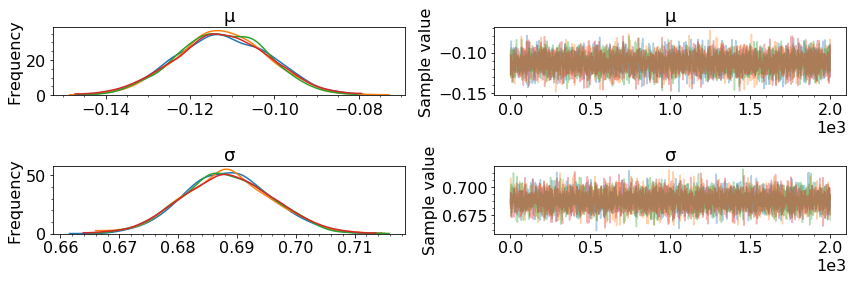

In [50]:
pm.traceplot(trace_m1);

In [51]:
pm.summary(trace_m1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,-0.112429,0.010799,0.000122,-0.133757,-0.092157,8203.378009,0.999830
σ,0.688269,0.007541,0.000087,0.674081,0.703340,8465.172628,0.999814


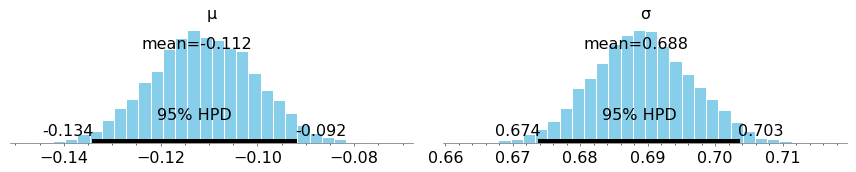

In [52]:
pm.plot_posterior(trace_m1, text_size=16);

[Back to Contents](#TOP)

<a id='Reg'></a>

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    $\rightarrow$~~The basics~~<br>
    $\rightarrow$~~Starting easy: inferring chlorophyll distribution~~<br>
    <font color='red'>$\rightarrow$Regression: adding a predictor to estimate chlorophyll</font>

[Back to Contents](#TOP)
<a id='RegPyMC3'></a>

## Regression: Adding a  predictor to estimate chlorophyll
* <font color=red>Writing a regression model in PyMC3</font>
* Do priors make sense?
* Data review, model fitting and posterior mining 
* Flavors of uncertainty

In [53]:
df_data.head().T

,0,1,2,3,4
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778
rrs510_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.70144
rrs555_l,-2.26695,-2.36376,-2.34046,-2.59924,-2.80625
rrs670_l,-3.07818,-3.13471,-3.16042,-3.50443,-3.79611
mxBl_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.6778
mxBlId2,rrs510,rrs510,rrs510,rrs510,rrs510
mxBlId,rrs510,rrs510,rrs510,rrs510,rrs489
MxBl-Gr2,-0.0257098,-0.0242776,-0.0205022,0.0399411,0.104812


Invert the blue/green ratio (green/blue) to make it more intuitive (blue baseline-corrected greenness increases with chlorophyll)

In [54]:
df_data['Gr-MxBl'] = -1 * df_data['MxBl-Gr']

Linear regression takes the form
$$ y = \alpha + \beta x $$
where<br> 
        $\ \ \ \ \ y = log_{10}(chl)$ and $x = \frac{Gr}{MxBl}$


Make the regression parameters interpretable by centering the predictor variable:
$x_c = x - \bar{x}$

In [55]:
df_data['Gr-MxBl_c'] = df_data['Gr-MxBl'] - df_data['Gr-MxBl'].mean()

$$ y = \alpha + \beta x_c$$<br>
$\rightarrow \alpha=y$ when $x=\bar{x}$<br>
$\rightarrow \beta=\Delta y$ when $x$ increases by one unit

In [56]:
x_c = df_data.dropna()['Gr-MxBl_c'].values
y = df_data.dropna().chl_l.values

In [57]:
with pm.Model() as m2:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    μ = α + β * x_c
    
    σ = pm.Uniform('σ', lower=0, upper=2)
    lkl = pm.Normal('likelihood', mu=μ, sd=σ,
                    observed=y)

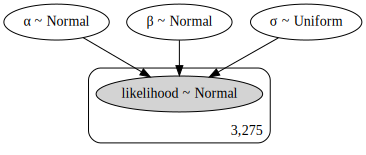

In [58]:
pm.model_to_graphviz(m2)

[Back to Contents](#TOP)
<a id='PriorCheck'></a>

##### Regression: Adding a  predictor to estimate chlorophyll
* ~~Writing a regression model in PyMC3~~
* <font color=red>Do priors make sense?</font>
* Data review, model fitting and posterior mining
* Flavors of uncertainty

Parameter Priors:

In [59]:
prior = pm.sample_prior_predictive(samples=1000, model=m2, vars=['α', 'β', 'σ', 'likelihood'])

In [60]:
x_dummy = np.linspace(-1.5, 1.5, num=50).reshape(-1, 1)

In [61]:
α_prior = prior['α'].reshape(1, -1)
β_prior = prior['β'].reshape(1, -1)
σ_prior = prior['σ'].reshape(1, -1)
chl_l_prior_μ = α_prior + β_prior * x_dummy
chl_l_prior_predictive = np.random.normal(loc=0, scale=σ_prior)
hpd_prior_predictive = pm.hpd(chl_l_prior_predictive.T)

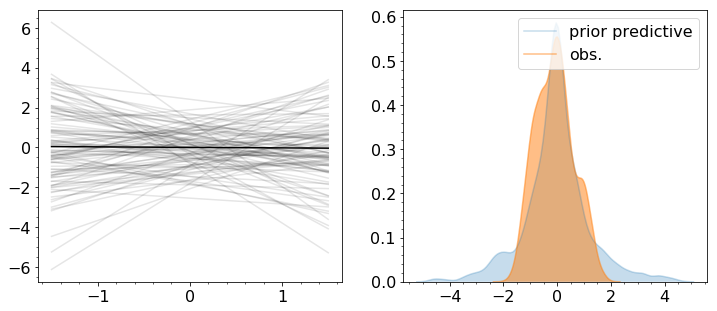

In [72]:
f, axs = pl.subplots(ncols=2, figsize=(12, 5))
axs[0].plot(x_dummy, chl_l_prior_μ.mean(axis=1), color='k', label='model prior')
axs[0].plot(x_dummy, chl_l_prior_μ[:, ::10], color='k', alpha=0.1,);
#axs[0].fill_between(x_dummy.flatten(), y1=hpd_prior_predictive[:, 0],
#                    y2=hpd_prior_predictive[:, 1], alpha=0.3, label='prior predictive checks');
#axs[0].scatter(x_c[::10], y[::10], edgecolor='k', label='obs.', alpha=0.5, color='darkorange');
#axs[0].legend()
sb.kdeplot(chl_l_prior_predictive.flatten(), shade=True, alpha=0.25, ax=axs[1], label='prior predictive');
sb.kdeplot(y, shade=True, alpha=0.5, ax=axs[1],label='obs.');
f.savefig('./figJar/Presentation/prior_checks_1.svg')

In [ ]:
with pm.Model() as m3:
    α = pm.Normal('α', mu=0, sd=0.5)
    β = pm.Normal('β', mu=0, sd=0.5)
    σ = pm.Uniform('σ', lower=0, upper=2)
    μ = α + β * x_c
    lkl = pm.Normal('likelihood', mu=μ, sd=σ,
                    observed=y)

In [ ]:
prior = pm.sample_prior_predictive(samples=1000, model=m3,
                                   vars=['α', 'β'])

In [ ]:
α_prior = prior['α'].reshape(1, -1)
β_prior = prior['β'].reshape(1, -1)
chl_l_prior = α_prior + β_prior * x_dummy

In [ ]:
pl.plot(x_dummy, chl_l_prior, color='k', alpha=0.01);
pl.ylabel('log_{10}(chl)')
pl.xlabel('centered log(Gr-to-MaxBlue)');

In [ ]:
with pm.Model() as m4:
    α = pm.Normal('α', mu=0, sd=0.5)
    β = pm.HalfNormal('β', sd=0.5)
    #σ = pm.Uniform('σ', lower=0, upper=2)
    σ = pm.Exponential('σ', lam=1)
    μ = α + β * x_c
    lkl = pm.Normal('likelihood', mu=μ, sd=σ,
                    observed=y)

In [ ]:
prior = pm.sample_prior_predictive(samples=1000, model=m4,
                                   vars=['α', 'β'])

In [ ]:
α_prior = prior['α'].reshape(1, -1)
β_prior = prior['β'].reshape(1, -1)
chl_l_prior = α_prior + β_prior * x_dummy

In [ ]:
pl.plot(x_dummy, chl_l_prior, color='k', alpha=0.01);
pl.ylabel('log_{10}(chl)')
pl.xlabel('centered log(Gr-to-MaxBlue)');

[Back to Contents](#TOP)
<a id='Mining'></a>

##### Regression: Adding a  predictor to estimate chlorophyll
* ~~Writing a regression model in PyMC3~~
* ~~Do my priors make sense?~~
* <font color=red>Data review, model fitting and posterior mining</font>
* Flavors of uncertainty

In [ ]:
g3 = sb.PairGrid(df_data.loc[:, ['Gr-MxBl', 'chl_l']],
                         diag_sharey=False)
g3.map_diag(sb.kdeplot, )
g3.map_offdiag(sb.scatterplot);
make_lower_triangle(g3)

In [ ]:
with m3:
    trace_m3 = pm.sample(2000, tune=1000, chains=4)
with m4:
    trace_m4 = pm.sample(2000, tune=1000, chains=4)

In [ ]:
ar.style.use('arviz-darkgrid')
ar.plot_forest([trace_m3, trace_m4], model_names=['m3', 'm4'], var_names=['β']);

[Back to Contents](#TOP)
<a id='UNC'></a>

##### Regression: Adding a  predictor to estimate chlorophyll
* ~~Writing a regression model in PyMC3~~
* ~~Do my priors make sense?~~
* ~~Data review, model fitting and posterior mining~~
* <font color=red>Flavors of uncertainty</font>

$\rightarrow$ model uncertainty: uncertainty around the mean
$\rightarrow$ prediction uncertainty: posterior predictive checks

--o--

#### Probabilistic modeling for the not-beginner
* More complicated models
    * polynomial regression
    * splines
    * empirical vs. semi-analytical: a useful dichotomy?
* Comparing models through information theory
* Multi-level models:
    * Pooled, unpooled and partially pooled models.
    * Hierarchical probabilistic models
    * Solving the regional vs. global quandary